# Naive Bayes

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn import model_selection

from itertools import cycle
%matplotlib inline 

warnings.filterwarnings('ignore')

## Functions

In [2]:
def get_model_metrics(y_val, predictions, model_name):
    conf_matrix = confusion_matrix(y_val, predictions)
    accu = accuracy_score(y_val, predictions)
    _recall_score = recall_score(y_val, predictions, average='weighted')
    _precision_score = precision_score(y_val, predictions, average='weighted')
    _f1_score = f1_score(y_val, predictions, average='weighted')

    print(f"\n---Metrics for {model_name}---")
    print("\n Confusion Matrix\n", conf_matrix)
    print("\n Accuracy", accu)
    print("\n Precision", _precision_score)
    print("\n Recall", _recall_score)
    print("\n F1 Score", _f1_score)
    
    return conf_matrix

In [3]:
def get_roc_curves(y, y_pred):
    y_ = label_binarize(y, classes=[0, 1])
    pred = label_binarize(y_pred, classes=[0,1])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes=1
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(
        fpr[0],
        tpr[0],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[0],
    )
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def k_fold_val(model, X, y, model_name, splits=5):
    # Validation of model after train with train data
    k_folds_model_train = model_selection.KFold(n_splits=splits, shuffle=True, random_state=79)
    k_folds_model_train.get_n_splits(X)
    scores = model_selection.cross_val_score(model, X, y, cv=k_folds_model_train)
    print(f"---k-fold scores for {model_name}---")
    print("Scores are: ", scores)
    print("Mean is: ", np.mean(scores))
    print("STD is: +-", np.std(scores))

## Load data

In [5]:
X_columns = ['AVProductsInstalled',
             'SmartScreen',
             'AVProductStatesIdentifier',
             'Census_OSArchitecture',
             'AppVersion_2',
             'Census_TotalPhysicalRAM',
             'IsProtected',
             'EngineVersion',
             'Census_SystemVolumeTotalCapacity',
             'AppVersion_3',
             'Census_FirmwareVersionIdentifier',
             'Census_ProcessorModelIdentifier',
             'Census_OEMModelIdentifier',
             'CountryIdentifier',
             'OrganizationIdentifier'
             ]

target = ['HasDetections']

In [6]:
df_train = pd.read_csv('./datasets/train_preprocessed.csv', usecols=X_columns + target)

In [7]:
# We'll use whole df
# df_train = df_train.sample(frac = 0.5)

In [8]:
print(f"Train dataset shape: {df_train.shape}")

Train dataset shape: (7667792, 16)


## Data Split & Model

In [9]:
X = df_train.drop("HasDetections", axis=1)
y = df_train["HasDetections"]

del df_train

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=31)

In [11]:
clf = make_pipeline(StandardScaler(), GaussianNB())

In [12]:
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

## Metrics

In [13]:
y_pred= clf.predict(x_test)

In [14]:
conf_matrix = get_model_metrics(y_test, y_pred, 'Naive Bayes')


---Metrics for Naive Bayes---

 Confusion Matrix
 [[292569 472794]
 [171606 596590]]

 Accuracy 0.5798009727698771

 Precision 0.594023529828469

 Recall 0.5798009727698771

 F1 Score 0.5627712303369032


## ROC Curve

In [15]:
 y_score = clf.predict_proba(x_test)

In [16]:
y_test.shape

(1533559,)

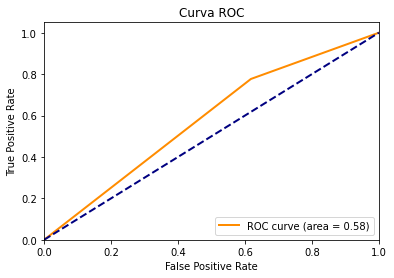

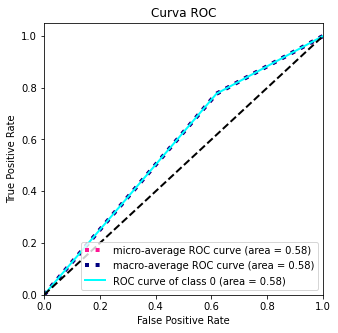

In [17]:
get_roc_curves(y_test,y_pred)

## K - folds

In [18]:
k_fold_val(clf, X, y, "Naive Bayes", splits = 10)

---k-fold scores for Naive Bayes---
Scores are:  [0.58048723 0.57923916 0.57937033 0.57995459 0.57871042 0.57989981
 0.57971071 0.57909645 0.57998589 0.57968332]
Mean is:  0.5796137922756899
STD is: +- 0.0004895788250799601


## Test Predictions

In [19]:
df_test = pd.read_csv('./datasets/test_preprocessed.csv', usecols=X_columns)

In [20]:
# df_test = df_test.sample(frac = 0.5)

In [21]:
pred = clf.predict(df_test[X_columns])

In [23]:
df_test['predictions'] = pred

In [30]:
df_test['predictions'][0:10]

5137437    1
3812197    1
7218464    0
5485084    1
2051912    1
1767961    1
2591048    0
1575749    1
5346961    1
347510     1
Name: predictions, dtype: int8